# Luca & Theo first analysis of the Phillips curve

### Date started 3 March 2024
### Premise
We'd like to have a quick look at some data in order to dive into the skills expected of a data analyst, so we will:
1. Search for the relevant data online
2. Import it and create some graphs
3. See if we can reproduce the Phillips curve econometric results

In [1]:
# setup & imports

import sys

#!{sys.executable} -m pip install pandas
#!{sys.executable} -m pip install matplotlib
#!{sys.executable} -m pip install scipy
#!{sys.executable} -m pip install seaborn
#!{sys.executable} -m pip install statsmodels

import pandas as pd
import matplotlib.pyplot as plt

In [2]:
inflation = pd.read_csv("data/inflation.csv")

In [3]:
inflation.columns = ['year', 'inflation']

In [4]:
unemployment = pd.read_csv("data/unemployment.csv")

In [5]:
unemployment.columns = ['month', 'unemployment']

In [6]:
# now we aggregate the unemployment data from the monthly level to the yearly one

# create the yearly date out of the monthly string date
unemployment['year'] = [date_string[:4] + '-01-01' for date_string in unemployment['month']]

unemployment.head(15)

,month,unemployment,year
0,1960-01-01,5.2,1960-01-01
1,1960-02-01,4.8,1960-01-01
2,1960-03-01,5.4,1960-01-01
3,1960-04-01,5.2,1960-01-01
4,1960-05-01,5.1,1960-01-01
5,1960-06-01,5.4,1960-01-01
6,1960-07-01,5.5,1960-01-01
7,1960-08-01,5.6,1960-01-01
8,1960-09-01,5.5,1960-01-01
9,1960-10-01,6.1,1960-01-01


In [7]:
# create a new dataframe to store the aggregated data
unemployment_yearly = pd.DataFrame(columns=['year', 'unemployment'])

# create a variable to use for filling the new dataframe
df_construction_index = 0

for year in unemployment.year.unique():
    # we take the subset of the year, calculate the avg, add it to the df, iterate
    subset = unemployment[unemployment['year'] == year]
    yearly_unemployment_average = subset['unemployment'].astype(float).mean()

    # add the newly calculated values to the results dataframe
    unemployment_yearly.loc[df_construction_index, 'year'] = year
    unemployment_yearly.loc[df_construction_index, 'unemployment'] = yearly_unemployment_average

    # increase the index so we can use it for the next row as well
    df_construction_index += 1

unemployment_yearly.sort_values(by=['year'], inplace=True)

unemployment_yearly.head(10)

# alternative method using groupby()
# unemployment_yearly_gb = unemployment.groupby('year')['unemployment'].mean()

,year,unemployment
0,1960-01-01,5.541667
1,1961-01-01,6.691667
2,1962-01-01,5.566667
3,1963-01-01,5.641667
4,1964-01-01,5.158333
5,1965-01-01,4.508333
6,1966-01-01,3.791667
7,1967-01-01,3.841667
8,1968-01-01,3.558333
9,1969-01-01,3.491667


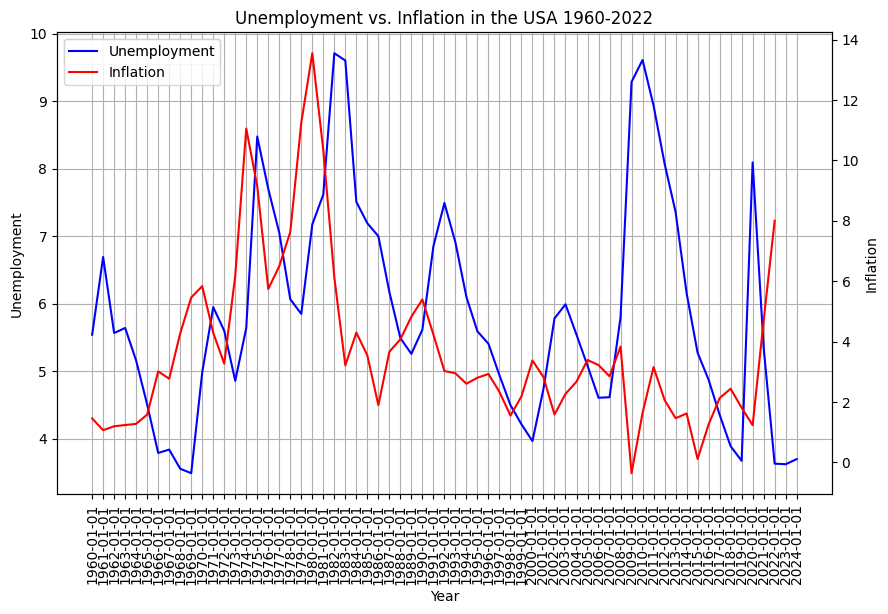

In [8]:
# now let's plot unemployment vs. inflation on opposing y-axes
fig, ax = plt.subplots(figsize=(10, 6))
axb = ax.twinx()

# Same as above
ax.set_xlabel('Year')
ax.set_ylabel('Unemployment')
ax.set_title('Unemployment vs. Inflation in the USA 1960-2022')
ax.grid(True)

# Plotting on the first y-axis
ax.plot(unemployment_yearly.year, unemployment_yearly.unemployment, color='blue', label='Unemployment')
ax.legend(loc='upper left')

ax.tick_params(axis='x', labelrotation=90)
# Plotting on the second y-axis
axb.set_ylabel('Inflation')
axb.plot(inflation.year, inflation.inflation, color='red', label='Inflation')

#ax.xaxis.set_major_locator(DayLocator())
#ax.xaxis.set_major_formatter(DateFormatter('%Y/%m'))

# Handling of getting lines and labels from all axes for a single legend
lines, labels = ax.get_legend_handles_labels()
lines2, labels2 = axb.get_legend_handles_labels()
axb.legend(lines + lines2, labels + labels2, loc='upper left')

## Statistical tests

#### Idea
Now we'll play around with statistical concepts and tests for some practice. We will:
1. Test for stationarity - if not stationary, do decomposition 
2. Check for correlation between the two variables
3. Try to test the Phillips curve relationship via regression
4. Run the Granger causality test to see if we detect the relationship in the data

In [9]:
from statsmodels.tsa.stattools import adfuller

In [10]:
adfuller(unemployment_yearly['unemployment'])

(-3.45830417054976,
 0.009124770643745393,
 1,
 63,
 {'1%': -3.5386953618719676,
  '5%': -2.9086446751210775,
  '10%': -2.591896782564878},
 165.71287146046632)

In [11]:
# according to the documentation https://www.statsmodels.org/dev/generated/statsmodels.tsa.stattools.adfuller.html
# the first element of the output is the test statistic, and the second one is the p-value

# The H0 (null hypothesis) of the test is that the series is NOT stationary
# if the p-value is less than 0.05, that means we reject the null hypothesis
# which means that our data IS stationary

# the conclusion is that unemployment is stationary (in our data)

In [12]:
adfuller(inflation['inflation'])

(-2.1572928774205193,
 0.22210900231410036,
 2,
 60,
 {'1%': -3.5443688564814813,
  '5%': -2.9110731481481484,
  '10%': -2.5931902777777776},
 200.32839547146003)

In [13]:
# in the case of inflation, we cannot reject the null hypothesis that the series is Not stationary

# therefore, inflation is not stationary
# we will therefore difference it in an attempt to make it stationary

In [14]:
inflation['inflation_1_diff'] = inflation.inflation.diff()

In [15]:
adfuller(inflation['inflation_1_diff'][~pd.isnull(inflation['inflation_1_diff'])])
# ~pd.isnull(inflation['inflation_1_diff']) this removes the rows in which inflation_1_diff is null
# which is the first observation, because there is no previous one to difference it against, so it's blank
# the command basically works by negating the vector of [is the value in this column null?]
# which in this case would return [True False False ... False]
# so when we take ~vector, we get [False True True ... True]
# and we only keep the rows which are "True"

(-7.124106767350544,
 3.6579749056983413e-10,
 1,
 60,
 {'1%': -3.5443688564814813,
  '5%': -2.9110731481481484,
  '10%': -2.5931902777777776},
 199.09302600503347)

In [16]:
# now the p-value is basically 0, so inflation 1diff is stationary

In [17]:
from statsmodels.tsa.seasonal import seasonal_decompose

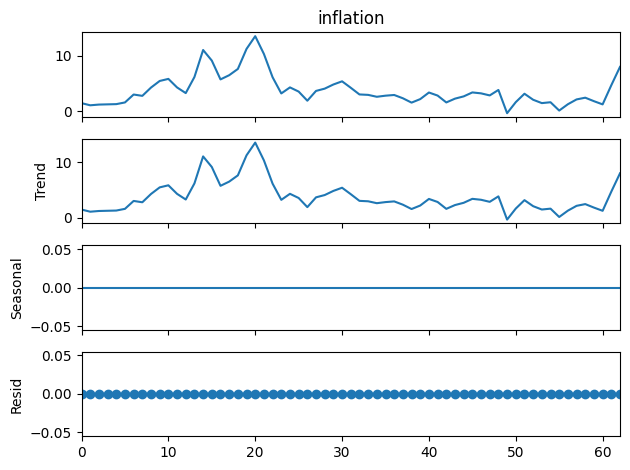

In [18]:
result = seasonal_decompose(inflation['inflation'], model='additive', period=1)
result.plot()
plt.show()

In [19]:
# when we try to decompose inflation into trend + seasonality, we fail to find any seasonality (at least visually,
# but more advanced methods like the ACF and PACF would probably confirm it), which suggestst that the reason
# why the ADF test came back negative is not because the data is non-stationary due to the existence of a trend
# but is rather non-stationary because its covariance is not constant across time (look at the big bump at the start)

In [20]:
# let's compile one dataframe with both inflation and unemployment so we can easily check for correlation
# and also more easily run regressions, add lags, etc.

In [21]:
phillips = unemployment_yearly.merge(inflation, how='left', left_on=['year'], right_on=['year'])
phillips.head(10)

,year,unemployment,inflation,inflation_1_diff
0,1960-01-01,5.541667,1.457976,NaN
1,1961-01-01,6.691667,1.070724,-0.387252
2,1962-01-01,5.566667,1.198773,0.128049
3,1963-01-01,5.641667,1.239669,0.040896
4,1964-01-01,5.158333,1.278912,0.039242
5,1965-01-01,4.508333,1.585169,0.306258
6,1966-01-01,3.791667,3.015075,1.429906
7,1967-01-01,3.841667,2.772786,-0.242290
8,1968-01-01,3.558333,4.271796,1.499011
9,1969-01-01,3.491667,5.462386,1.190590


In [22]:
# phillips.tail(5)
# the data seems to have some NaNs at the end, so we'll trim it now
phillips = phillips.loc[:62, :]
phillips.tail(4)

,year,unemployment,inflation,inflation_1_diff
59,2019-01-01,3.675,1.812210,-0.630373
60,2020-01-01,8.091667,1.233584,-0.578626
61,2021-01-01,5.35,4.697859,3.464274
62,2022-01-01,3.633333,8.002800,3.304941


In [23]:
# let's also add lags 1, 2, 3, 4, and 5 to both unemployment and inflation 1_diff

phillips['unemployment'] = phillips['unemployment'].astype(float)

phillips['unemployment_1_lag'] = phillips['unemployment'].shift(1)
phillips['unemployment_2_lag'] = phillips['unemployment'].shift(2)
phillips['unemployment_3_lag'] = phillips['unemployment'].shift(3)
phillips['unemployment_4_lag'] = phillips['unemployment'].shift(4)

phillips['inflation_1_diff_1_lag'] = phillips['inflation_1_diff'].shift(1)
phillips['inflation_1_diff_2_lag'] = phillips['inflation_1_diff'].shift(2)
phillips['inflation_1_diff_3_lag'] = phillips['inflation_1_diff'].shift(3)
phillips['inflation_1_diff_4_lag'] = phillips['inflation_1_diff'].shift(4)

phillips.head(10)

,year,unemployment,inflation,inflation_1_diff,unemployment_1_lag,unemployment_2_lag,unemployment_3_lag,unemployment_4_lag,inflation_1_diff_1_lag,inflation_1_diff_2_lag,inflation_1_diff_3_lag,inflation_1_diff_4_lag
0,1960-01-01,5.541667,1.457976,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1961-01-01,6.691667,1.070724,-0.387252,5.541667,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1962-01-01,5.566667,1.198773,0.128049,6.691667,5.541667,NaN,NaN,-0.387252,NaN,NaN,NaN
3,1963-01-01,5.641667,1.239669,0.040896,5.566667,6.691667,5.541667,NaN,0.128049,-0.387252,NaN,NaN
4,1964-01-01,5.158333,1.278912,0.039242,5.641667,5.566667,6.691667,5.541667,0.040896,0.128049,-0.387252,NaN
5,1965-01-01,4.508333,1.585169,0.306258,5.158333,5.641667,5.566667,6.691667,0.039242,0.040896,0.128049,-0.387252
6,1966-01-01,3.791667,3.015075,1.429906,4.508333,5.158333,5.641667,5.566667,0.306258,0.039242,0.040896,0.128049
7,1967-01-01,3.841667,2.772786,-0.242290,3.791667,4.508333,5.158333,5.641667,1.429906,0.306258,0.039242,0.040896
8,1968-01-01,3.558333,4.271796,1.499011,3.841667,3.791667,4.508333,5.158333,-0.242290,1.429906,0.306258,0.039242
9,1969-01-01,3.491667,5.462386,1.190590,3.558333,3.841667,3.791667,4.508333,1.499011,-0.242290,1.429906,0.306258


<Axes: >

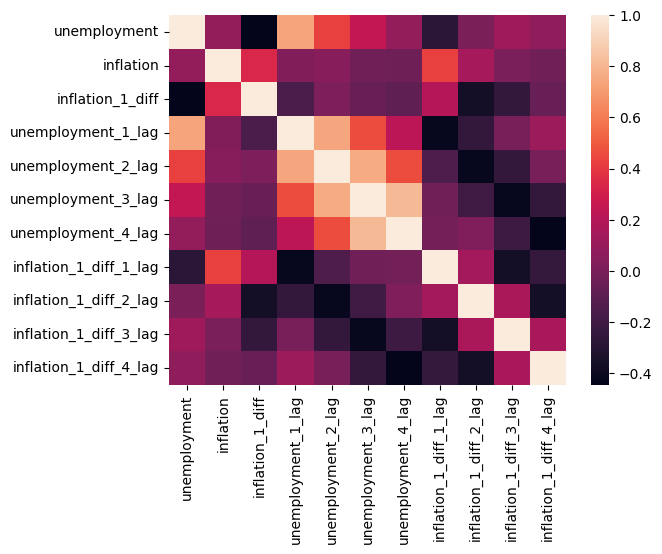

In [24]:
import seaborn as sns

# calculate the correlation matrix on the numeric columns
corr = phillips.loc[~pd.isnull(phillips['unemployment_4_lag']), :].select_dtypes('number').corr()

# plot the heatmap
sns.heatmap(corr)

In [25]:
# the heat map reveals strong negative correltaion between unemployment and inflation_1_diff, so we'll only keep those
# two columns going forward and use them for everthing else
phillips = phillips[['year', 'unemployment', 'inflation_1_diff']]

phillips = phillips[~pd.isnull(phillips['inflation_1_diff'])]

phillips.head(5)

,year,unemployment,inflation_1_diff
1,1961-01-01,6.691667,-0.387252
2,1962-01-01,5.566667,0.128049
3,1963-01-01,5.641667,0.040896
4,1964-01-01,5.158333,0.039242
5,1965-01-01,4.508333,0.306258


In [26]:
from scipy.stats import pearsonr

pearsonr(phillips['unemployment'], phillips['inflation_1_diff'])

PearsonRResult(statistic=-0.4455788027246878, pvalue=0.00028430102423952975)

In [27]:
# we got a very low p-value, which means really strong significance => we're pretty sure they are correlated

In [28]:
import numpy as np

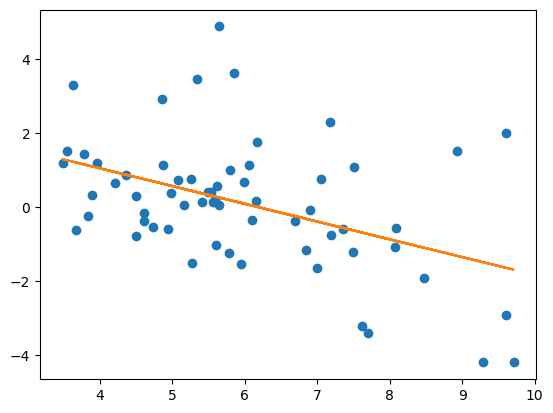

In [29]:
# code from: https://www.statology.org/scatterplot-with-regression-line-python/
m, b = np.polyfit(phillips['unemployment'], phillips['inflation_1_diff'], 1)

# add linear regression line to scatterplot 
plt.plot(phillips['unemployment'], phillips['inflation_1_diff'], 'o')
plt.plot(phillips['unemployment'], m*phillips['unemployment']+b)

In [30]:
# this scatterplot & line from a regression seem to cofirm the relationship
# so we will also just run a linear regression as final check
import statsmodels.formula.api as smf

mod = smf.ols('unemployment ~ inflation_1_diff', data=phillips)
res = mod.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:           unemployment   R-squared:                       0.199
Model:                            OLS   Adj. R-squared:                  0.185
Method:                 Least Squares   F-statistic:                     14.86
Date:                Sun, 10 Mar 2024   Prob (F-statistic):           0.000284
Time:                        21:39:43   Log-Likelihood:                -110.39
No. Observations:                  62   AIC:                             224.8
Df Residuals:                      60   BIC:                             229.0
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept            6.0029      0.186  

In [31]:
# let's also run the regression with robust standard errors
phillips_model_with_robust_standard_errors = res.get_robustcov_results(cov_type='HC1', use_t=None)
print(phillips_model_with_robust_standard_errors.summary())

                            OLS Regression Results                            
Dep. Variable:           unemployment   R-squared:                       0.199
Model:                            OLS   Adj. R-squared:                  0.185
Method:                 Least Squares   F-statistic:                     12.47
Date:                Sun, 10 Mar 2024   Prob (F-statistic):           0.000803
Time:                        21:39:44   Log-Likelihood:                -110.39
No. Observations:                  62   AIC:                             224.8
Df Residuals:                      60   BIC:                             229.0
Df Model:                           1                                         
Covariance Type:                  HC1                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept            6.0029      0.184  

In [32]:
# Let's interpret the regression and the result

# First of all, we used linear regression with intercept (rather than without) because that reflects
# The structural unemployment rate that will always exist. This seems to be 6%, equal to the intercept

# We also ran the regression with robust standard errors to account for any potential heteroskedasticity 
# And found that the relationship still holds (the coefficient for inflation_1_diff is still significant with p=0.001)

# Further, we found the coefficient for inflation_1_diff to be negative, which aligns with the Phillips curve theory, confirming it
# Moreover, its magnitude is basically equal to the correlation coefficient we found above, which is also a good sign
# Based on the coefficient for inflation, it seems that any 1% increase corresponds to a lowering of the unemployment rate
# of 0.4%.

# Example: if natural unemployment is 6%, and inflation in the current year is up 3% compared to the previous one
# Then unemployment will be = 6 - (3 * (-0.4)) = 6 - 1.2 = 4.8%

In [33]:
# Final step: Granger causality test

# The intuition behind the Granger causality test is that we have two time series, A and B, and we suspect that one may cause the other
# So what we do, is we test if past values of A predict current values of B, and if past values of B predict current values of A

# If A turns out to statistically-significantly predict B, but B does not statistically-significantly predict A
# Then A Granger-causes B

# Please not this is more like a statistical gimmick than actual legit statistical practice, because you are basically hacking
# inferrence instead of achieving it the proper way, so do be careful how you use this

from statsmodels.tsa.stattools import grangercausalitytests


In [34]:
#perform Granger-Causality test
for value in range(1, 5):
    print("\n\n" + str(grangercausalitytests(phillips[['inflation_1_diff', 'unemployment']], maxlag=[value])))
    print("\n\n" + str(grangercausalitytests(phillips[['unemployment', 'inflation_1_diff']], maxlag=[value])))


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.4141  , p=0.5224  , df_denom=58, df_num=1
ssr based chi2 test:   chi2=0.4355  , p=0.5093  , df=1
likelihood ratio test: chi2=0.4340  , p=0.5100  , df=1
parameter F test:         F=0.4141  , p=0.5224  , df_denom=58, df_num=1


{1: ({'ssr_ftest': (0.41412095564816653, 0.522421687218195, 58.0, 1), 'ssr_chi2test': (0.4355410050782441, 0.5092825115474567, 1), 'lrtest': (0.4339934819626876, 0.5100358853739938, 1), 'params_ftest': (0.4141209556481478, 0.5224216872182016, 58.0, 1.0)}, [<statsmodels.regression.linear_model.RegressionResultsWrapper object at 0x000001E978269D00>, <statsmodels.regression.linear_model.RegressionResultsWrapper object at 0x000001E97827A7E0>, array([[0., 1., 0.]])])}

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0849  , p=0.7719  , df_denom=58, df_num=1
ssr based chi2 test:   chi2=0.0892  , p=0.7651  , df=1
likelihood ratio test: chi2=0.0892  , p=0.7652  , df=1
pa

In [35]:
# None of the p-values are below 0.05, so neither inflation_1_diff nor unemployment seem to Granger-cause the other
# Which means that the two values are connected at lag 0, and they seem to represent a correlation
# That is most likely (to our minds minds at least) caused by a confounding factor rather than one of them
# Influencing the other